In [4]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import (ColumnTransformer, TransformedTargetRegressor)
from sklearn.base import (BaseEstimator, TransformerMixin)
from sklearn.preprocessing import (StandardScaler, RobustScaler, OneHotEncoder, FunctionTransformer)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Random forrest classiifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from sklearn import set_config
import pickle
import matplotlib.pyplot as plt

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

C:\Users\noona\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Read in data

In [6]:
df = pd.read_csv("./insurance.csv")
df.head()

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

In [4]:
df.tail()

age  gender     bmi  children smoker     region  insurance_cost
1333   64  female  31.825         2     no  northeast     16069.08475
1334   64  female  26.885         0    yes  northwest     29330.98315
1335   64    male  26.410         0     no  northeast     14394.55790
1336   64    male  36.960         2    yes  southeast     49577.66240
1337   64    male  23.760         0    yes  southeast     26926.51440

Replace the column `insurance_cost` with a binary column `insurance_cost_binary`

Find median

In [7]:
# Assuming df is your DataFrame and 'column_name' is the name of the column
median_insurance_cost = df['insurance_cost'].median()

print("Median of the insurancce cost:", median_insurance_cost)

Median of the insurancce cost: 9382.033


In [8]:
# Replace with binary
# Define a function to map insurance cost to binary values
def map_to_binary(value):
    if value <= median_insurance_cost:
        return 0
    else:
        return 1

# Apply the function to create the new binary column
df['insurance_cost_binary'] = df['insurance_cost'].apply(lambda x: map_to_binary(x))

# Drop the original 'insurance_cost' column
df.drop(columns=['insurance_cost'], inplace=True)

In [7]:
df.head()

age  gender     bmi  children smoker     region  insurance_cost_binary
0   18    male  33.770         1     no  southeast                      0
1   18    male  34.100         0     no  southeast                      0
2   18  female  26.315         0     no  northeast                      0
3   18  female  38.665         2     no  northeast                      0
4   18  female  35.625         0     no  northeast                      0

For each classifier, include data preparation and dimensionality reduction steps in the main pipeline.

In [8]:
df.isna().sum()

age                      0
gender                   0
bmi                      0
children                 0
smoker                   0
region                   0
insurance_cost_binary    0
dtype: int64

In [9]:
df.describe()

age          bmi     children  insurance_cost_binary
count  1338.000000  1338.000000  1338.000000            1338.000000
mean     39.207025    30.663397     1.094918               0.500000
std      14.049960     6.098187     1.205493               0.500187
min      18.000000    15.960000     0.000000               0.000000
25%      27.000000    26.296250     0.000000               0.000000
50%      39.000000    30.400000     1.000000               0.500000
75%      51.000000    34.693750     2.000000               1.000000
max      64.000000    53.130000     5.000000               1.000000

In [19]:
print(df.count())

age                      1338
gender                   1338
bmi                      1338
children                 1338
smoker                   1338
region                   1338
insurance_cost_binary    1338
dtype: int64


In [79]:
df.hist(bins=10, figsize=(25, 20));

In [9]:
preprocess_pipeline = ColumnTransformer(
    transformers = [
        ("no_outliers", StandardScaler(), ['age','bmi','children']),
        ("categorical", OneHotEncoder(drop='first', sparse_output=False), ['smoker','region','gender'])
    ],
    remainder=RobustScaler() # i.e. ['age']
).set_output(transform="pandas") 

In [10]:
y = df['insurance_cost_binary']
X = df.drop('insurance_cost_binary', axis=1)

In [12]:
X.head()

age  gender     bmi  children smoker     region
0   18    male  33.770         1     no  southeast
1   18    male  34.100         0     no  southeast
2   18  female  26.315         0     no  northeast
3   18  female  38.665         2     no  northeast
4   18  female  35.625         0     no  northeast

In [108]:
X_transformed = preprocess_pipeline.fit_transform(X);

In [109]:
X_transformed.head()

no_outliers__age  no_outliers__bmi  no_outliers__children  \
0         -1.509965          0.509621              -0.078767   
1         -1.509965          0.563756              -0.908614   
2         -1.509965         -0.713331              -0.908614   
3         -1.509965          1.312619               0.751079   
4         -1.509965          0.813924              -0.908614   

   categorical__smoker_yes  categorical__region_northwest  \
0                      0.0                            0.0   
1                      0.0                            0.0   
2                      0.0                            0.0   
3                      0.0                            0.0   
4                      0.0                            0.0   

   categorical__region_southeast  categorical__region_southwest  \
0                            1.0                            0.0   
1                            1.0                            0.0   
2                            0.0                            0.0   
3                            0.0                            0.0   
4                            0.0                            0.0   

   categorical__gender_male  
0                       1.0  
1                       1.0  
2                       0.0  
3                       0.0  
4                       0.0

Now, let's split the original dataset into a training and test datasets.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

### SVM

In [20]:
# create the pipeline
pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipeline), 
    ('reduce_dim', 'passthrough'),
    ('svm', svm.SVC(probability=True))
])

In [21]:
set_config(display="diagram")
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder=RobustScaler(),
                                   transformers=[('no_outliers',
                                                  StandardScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('categorical',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['smoker', 'region',
                                                   'gender'])])),
                ('reduce_dim', 'passthrough'), ('svm', SVC(probability=True))])

Now, let's train the model by exploring various combinations of values of the parameters of the predictor, i.e. SVM. Note that we can also add the parameters of the transformers (the ones included in the preprocessing pipeline) to the parameter grid.

In [22]:
param_grid = {
    'svm__C': [0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly']}

In [54]:
# Import addidtional dimesionality reduction technique
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [55]:
# prepare a parameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of svn.SVC and their possible values

N_FEATURES_OPTIONS=[2, 3]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'svm__C': [0.1, 1, 10, 100],  
        'svm__gamma': [1, 0.1, 0.01, 0.001], 
        'svm__kernel': ['rbf', 'linear', 'poly']
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'svm__C': [0.1, 1, 10, 100],  
        'svm__gamma': [1, 0.1, 0.01, 0.001], 
        'svm__kernel': ['rbf', 'linear', 'poly']
    },
        {
        'reduce_dim': [LinearDiscriminantAnalysis()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'svm__C': [0.1, 1, 10, 100],  
        'svm__gamma': [1, 0.1, 0.01, 0.001], 
        'svm__kernel': ['rbf', 'linear', 'poly']
    }
    
]


search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train) #training happens here! SVM is trained 48x5 = 240 times

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

C:\Users\noona\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
480 fits failed out of a total of 1920.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
480 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\pipeline.py", line 471, in fit
    Xt = self._fit(X, y, routed_params)
  File "C:\Users\noona\anaconda3\li

Best CV score = 0.932:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear')), 'reduce_dim__n_features_to_select': 3, 'svm__C': 100, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}


Test on unseen data

In [24]:
# Preprocess test data
X_test_processed = SVM_best_model['preprocess'].transform(X_test)

# If using dimensionality reduction
X_test_reduced = SVM_best_model['reduce_dim'].transform(X_test_processed)

# Apply trained model
predictions = SVM_best_model['svm'].predict(X_test_reduced)

# Evaluate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.9291044776119403


This is quite good accuracy

### Random Forest

In [32]:
# create the pipeline
piper = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('rf', RandomForestClassifier()
                       )
                      ]
               )

In [26]:
set_config(display="diagram")
piper

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder=RobustScaler(),
                                   transformers=[('no_outliers',
                                                  StandardScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('categorical',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['smoker', 'region',
                                                   'gender'])])),
                ('reduce_dim', 'passthrough'),
                ('ttr',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=RandomForestRegressor(n_estimators=10)))])

Now, let's train the model by exploring various combinations of values of the parameters of the predictor, i.e. Random Forest.

In [36]:
# prepare a parameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
N_FEATURES_OPTIONS = [2]
MAX_DEPTH_OPTIONS = [3]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'rf__n_estimators' : [10,20,30],
        'rf__max_depth': [2, 4, 6, 8]
    }
    ,
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'rf__n_estimators' : [10,20,30],
        'rf__max_depth': [2, 4, 6, 8]
    }  
]

search = GridSearchCV(piper, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.926:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear')), 'rf__max_depth': 4, 'rf__n_estimators': 30}


Some inifinty value issue I need to resolve

Test on unseen data

In [35]:
# Preprocess test data
X_test_processed = RF_best_model['preprocess'].transform(X_test)

# If using dimensionality reduction
X_test_reduced = RF_best_model['reduce_dim'].transform(X_test_processed)

# Apply trained model
predictions = RF_best_model['rf'].predict(X_test_reduced)

# Evaluate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.9104477611940298


This is good, a small bit worse than SVM.

### MLPClassifier

In [ ]:
from sklearn.neural_network import MLPClassifier

I will use Bayes search for this

In [65]:
from skopt import BayesSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
#Add more layers, my above experiments suggest 3 layers gives good results. This will increase complexity of my model.
class MLPWrapper(BaseEstimator, ClassifierMixin):
    
    def __init__(self, layer1=10, layer2=10, activation='logictic', solver='logistic'):
        self.layer1 = layer1
        self.layer2 = layer2
        self.activation = activation
        self.solver = solver

    def fit(self, X, y):
        model = MLPClassifier(
            hidden_layer_sizes=[self.layer1, self.layer2],
            max_iter = 1000,
            activation = self.activation,
            solver = self.solver
        )
        model.fit(X, y)
        self.model = model
        return self

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)    

    def score(self, X, y):
        return self.model.score(X, y)

In [67]:
# create the pipeline
pipe_mlp = Pipeline(steps=[('preprocess', preprocess_pipeline),
                           ('reduce_dim', 'passthrough'),
                           ('mlp', MLPWrapper())])

In [69]:
# Set the number of features
N_FEATURES_OPTIONS = [2, 4]

# Initialize BayesSearchCV with your pipeline and the search space
bayes_search = BayesSearchCV(
    pipe_mlp,
    search_spaces={
        'reduce_dim': [PCA()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'mlp__layer1': (2, 10),
        'mlp__layer2': (2, 10),
        'mlp__activation': ['relu'],# 'logistic'],
        #'learning_rate_init': (0.001, 0.1),
        #'alpha': (0.0001, 0.01),
        'mlp__solver':['adam']
    },
    n_iter=20  # Number of parameter settings that are sampled
)

# Fit BayesSearchCV to your data
bayes_search.fit(X_train, y_train)

BayesSearchCV(estimator=Pipeline(steps=[('preprocess',
                                         ColumnTransformer(remainder=RobustScaler(),
                                                           transformers=[('no_outliers',
                                                                          StandardScaler(),
                                                                          ['age',
                                                                           'bmi',
                                                                           'children']),
                                                                         ('categorical',
                                                                          OneHotEncoder(drop='first',
                                                                                        sparse_output=False),
                                                                          ['smoker',
                                                                           'region',
                                                                           'gender'])])),
                                        ('reduce_dim', 'passthrough'),
                                        ('mlp', MLPWrapper())]),
              n_iter=20,
              search_spaces={'mlp__activation': ['relu'],
                             'mlp__layer1': (2, 10), 'mlp__layer2': (2, 10),
                             'mlp__solver': ['adam'], 'reduce_dim': [PCA()],
                             'reduce_dim__n_components': [2, 4]})

In [70]:
# Get the best hyperparameters
best_params_nn = bayes_search.best_params_
print("Best Hyperparameters:", best_params_nn)

Best Hyperparameters: OrderedDict([('mlp__activation', 'relu'), ('mlp__layer1', 5), ('mlp__layer2', 10), ('mlp__solver', 'adam'), ('reduce_dim', PCA()), ('reduce_dim__n_components', 4)])


In [71]:
# Evaluate the best model on the test set
best_model_nn = bayes_search.best_estimator_

Check how well it performs on unseen data

In [72]:
# Preprocess test data
X_test_processed = best_model_nn['preprocess'].transform(X_test)

# If using dimensionality reduction
X_test_reduced = best_model_nn['reduce_dim'].transform(X_test_processed)

# Apply trained model
predictions = best_model_nn['mlp'].predict(X_test_reduced)

# Evaluate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.7761194029850746


This is not great accuracy

## Compare Classification Models on Test Set

Now we can evaluate the best models found by the grid search on the test dataset and compare their results (accuracy, precision, recall, etc.) to choose the better classifier for our problem.

The evaluation function below evaluates a model on a test data set. Note that, the preprocessing pipeline is automatically applied to the test set. The results returned by the function are a variety of metrics measured on the test set which we will use to compare the models and decide which classifier to choose for training the final model. These metrics are:

- accuracy
- precisions
- recall
- F1-score
- TPR (true positive rate)
- AUC (area under the ROC curve)

To plot ROC curves for the models, we need to ensure that the same false positive rate (fpr) scale is used for all curves. For this reason, we take a scale of 100 equally spaced fpr values between 0 and 1 and interpolate the true positive rate (tpr) for them.

In [44]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [59]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the model predicts probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

Now we use the function above to evaluate the best SVM and Random Forest models found by the grid search.

In [79]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)
MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score, MLP_tpr, ML_auc = evaluate_model(X_test, y_test, best_model_nn)

We use a Pandas bar plot to compare the accuracies of both models as well as their precision, recall and F1-score for class 1.

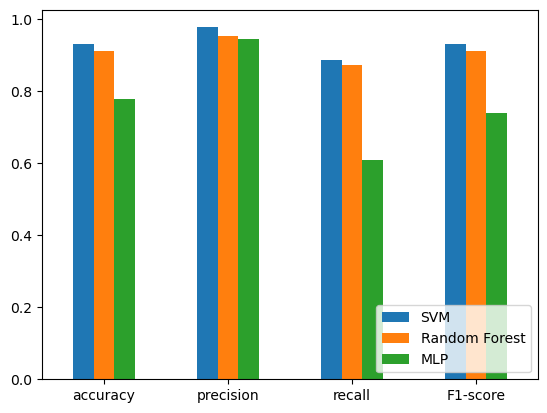

In [80]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
MLP_metrics = np.array([MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics, 'MLP': MLP_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

Both Random forret and SVM classification models perform well with SVM being better. The MLP model has a high precision. We can pick SVM to train a final model on the whole dataset. 

We can also examine the ROC curves of the two models for class 1.

In [48]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classification models')
plt.legend(loc="lower right")
plt.show()

The ROC curves confirm that both classification models perform significantly better than a random guess (the red dashed `no skill` line). 

## Train the Final Model

In [51]:
# function to remove the string 'svm__' from the names of the parameters in SVM_best_params
def transform(dict):
    return {key.replace('svm__','') :  value for key, value in dict.items()}

final_pipe = make_pipeline(preprocess_pipeline,SVM_best_model['reduce_dim'], SVM_best_model['svm'])

final_model =final_pipe.fit(X, y)

In [52]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))